In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile # for audio processing
import tensorflow
import warnings
warnings.filterwarnings("ignore")

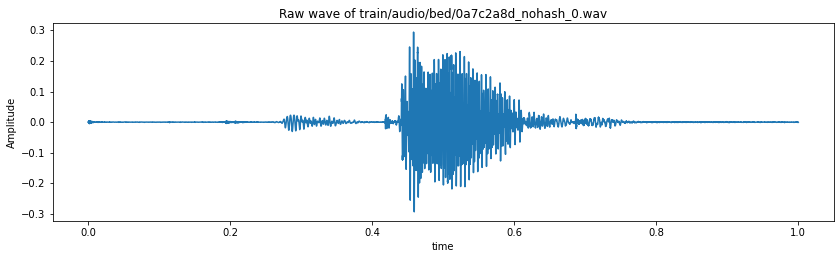

[-3.0517578e-05 -6.7138672e-04 -8.8500977e-04 ... -6.7138672e-04
 -5.4931641e-04 -5.4931641e-04]
16000


In [2]:
# Visualization of Audio signal in time series domain
train_audio_path = 'train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'bed/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'train/audio/bed/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
plt.show()

# sampling rate of the audio signals:
ipd.Audio(samples, rate=sample_rate)
print(samples)
print(sample_rate)


[-0.00042699 -0.00056748 -0.00054368 ... -0.00126125 -0.00098329
 -0.00056913]
['right', 'eight', 'cat', 'tree', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'nine', 'left', 'stop', 'three', '_background_noise_', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'off', 'four']


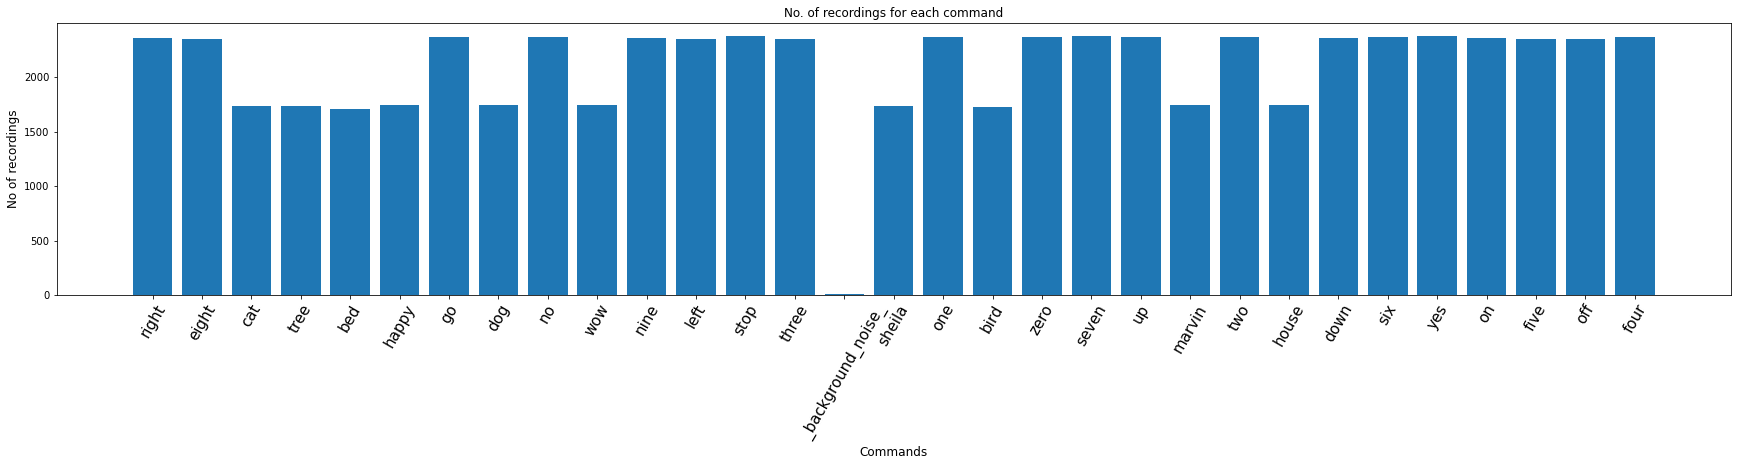

In [3]:
# Re-sample rate to 8000 Hz, since most of the speech-related frequencies are present at 8000 Hz:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)
print(samples)

# store all labels of wav files
labels = os.listdir(train_audio_path)
print(labels)

# find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
# RUN IN TERMINAL IF NEEDS BE: sudo find / -name '.DS_Store' -type f -delete

# plot bar graph
plt.figure(figsize=(30, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()


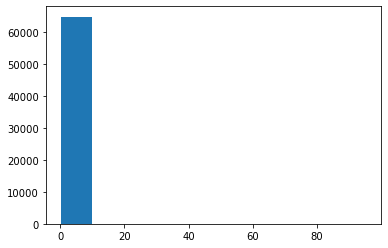

In [4]:
# WAV FILE DURATIONS PLOT: LOOK AT THE DISTRIBUTION OF THE DURATION OF RECORDINGS - WAIT A MIN FOR THIS...
duration_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples) / sample_rate))

plt.hist(np.array(duration_of_recordings))
plt.show()

In [5]:
# PREPROCESSING THE AUDIO WAVES - RESAMPLING FILES AND REMOVING SHORTER FILE COMMANDS OF LESS THAN 1 SECOND
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) :
            all_wave.append(samples)
            all_label.append(label)


right
eight
cat
tree
bed
happy
go
dog
no
wow
nine
left
stop
three
_background_noise_
sheila
one
bird
zero
seven
up
marvin
two
house
down
six
yes
on
five
off
four


In [7]:
#RETURNING POST TRAINING - restore all_wave array:
waves_list = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
print(labels)

['right', 'eight', 'cat', 'tree', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'nine', 'left', 'stop', 'three', '_background_noise_', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'off', 'four']


In [8]:
# CONVERT OUTPUT LABELS INTO VECTOR FORMAT
# First convert the output labels to integer encoded:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

# then convert integer encoded labels to a one-hot vector (since it is a multi-classification problem):
# VECTOR (spoken embedding) represents the unique features of the spoken utterance???
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))

# Reshape the 2D array to 3D - since the input to the conv1d (CNN base model) must be a 3D array
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [9]:
# SPLIT INTO TRAIN AND VALIDATION SET: train model on 80% of data and validate on remaining 20%
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [12]:
# BUILD SPEECH-TO-TEXT MODEL using conv1d
# Conv1d is a convolutional neural network which performs the convolution along only one dimension
# implement model using Keras functional API
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

2024-01-02 11:41:01.615081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Define loss function to be categorical cross-entropy (since it is a multi-classification problem):
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
# SKIP - IF MODEL TRAINED DO NOT NEED TO RUN
# # Early stopping and model checkpoints are callbacks to stop training the NN at right time and save the best model after every epoch:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
# mc = ModelCheckpoint('best_model.hdf5', metric='val_acc', verbose=1, save_best_only=True, mode='max')
# # mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')

In [62]:
# # SKIP - IF MODEL TRAINED DO NOT NEED TO RUN
# # train model on a batch size of 32 and evaluate performance on the holdout set:
# history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
1456/1457 [============================>.] - ETA: 0s - loss: 0.5244 - accuracy: 0.8405
Epoch 1: val_loss improved from -inf to 0.58159, saving model to best_model.hdf5
1457/1457 [==============================] - 158s 109ms/step - loss: 0.5244 - accuracy: 0.8405 - val_loss: 0.5816 - val_accuracy: 0.8307
Epoch 2/100
1456/1457 [============================>.] - ETA: 0s - loss: 0.5216 - accuracy: 0.8393
Epoch 2: val_loss improved from 0.58159 to 0.61661, saving model to best_model.hdf5
1457/1457 [==============================] - 157s 108ms/step - loss: 0.5216 - accuracy: 0.8393 - val_loss: 0.6166 - val_accuracy: 0.8230
Epoch 3/100
1456/1457 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.8423
Epoch 3: val_loss did not improve from 0.61661
1457/1457 [==============================] - 157s 108ms/step - loss: 0.5156 - accuracy: 0.8423 - val_loss: 0.6023 - val_accuracy: 0.8259
Epoch 4/100
1456/1457 [============================>.] - ETA: 0s - loss: 0.5159 

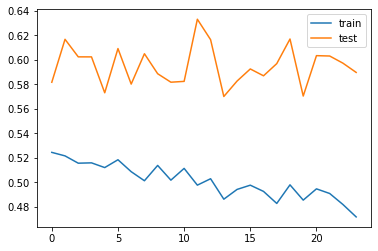

In [63]:
# # DIAGNOSTIC PLOT - IF MODEL TRAINED DO NOT NEED TO RUN
# # First training run 54 epochs. Second training run 18 epochs. Third training run 24 epochs.
# # visualization to understand performance of the model over period of time
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend() 
# pyplot.show()

In [14]:
# Load the best model
from keras.models import load_model
model=load_model('best_model.hdf5')

In [15]:
# Define function that predicts text for given audio
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [18]:
# Make predictions on validation data (WILL NEED x_val AND y_val FROM'SPLIT INTO TRAIN AND VALIDATION SET'& all_waves)
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: seven
1/1 [==============================] - 0s 14ms/step
Text: seven


In [33]:
# prompt user to record voice commands 
import sounddevice as sd
import soundfile as sf

samplerate = 16000
duration = 1 # seconds
filename = 'test.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
path = 'input'
# sf.write(filename, mydata, samplerate)
sf.write(os.path.join(path,filename), mydata, samplerate) 

start
end


In [34]:
# read saved voice command and convert it to text
os.listdir('input')
filepath='input'

# reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'test.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

predict(samples)

1/1 [==============================] - 0s 14ms/step


'happy'